In [4]:
#Imports
import covasim as cv
from datetime import date, timedelta

Covasim 2.1.2 (2021-03-31) — © 2021 by IDM


In [5]:
## Date Extraction
today = date.today()

# Function to format date into proper string
def format_day(date):
    return date.strftime("%Y-%m-%d")

In [151]:
# Adjust model params here
event_length = 5 
baseline_beta = 1
mitigation_beta = 1
pop = 1000

# TESTING
test_del = 0 # Test delay
days_testing = 0 # Number of days performing tests susceptibles
subtarg = None # Subtargetting of tests
sens = .95 # Sensitivity of test used

# For time to death, should we just make it kill immediately by adjusting exp2inf and crit2die? Or add 30 days to simulation?

# Get start and end date of event, starting today
d1 = format_day(today)
d2 = format_day(today + timedelta(days = event_length))

# Initialize model parameters
pars = dict(
    start_day = d1,
    end_day   = d2,
    pop_type  = 'hybrid',
    pop_size = pop,
    pop_infected = 100
)

# Note: this only works for cases generated at event. 
# For single entry testing only, run test_intervention(0,0)
def test_intervention(test_del, days_testing, subtarg=None, sens=1):

    #Todo: Add probability to sensitivity
    pars['pop_infected'] -= sens * pars['pop_infected']

    return cv.test_num(daily_tests=[pop]*days_testing, 
                       start_day=d1, 
                       subtarget=subtarg,
                       symp_test=0,
                       sensitivity=sens,
                       test_delay=test_del)

#test_int = cv.test_num(daily_tests=[0,1000,0], start_day=d1, end_day=d2)
#End of event intervention stops transmission once event ends





In [152]:
# Shared interventions
end_of_event = cv.change_beta(days=[d2], changes=[0]) # Transmission stops after event ends

# Baseline simulation
event_baseline = cv.dynamic_pars(beta=dict(days=list(range(event_length)), vals=[baseline_beta]*(event_length)))
orig_sim = cv.Sim(pars, interventions=[event_baseline, end_of_event], label='Baseline')

# Mitigation interventions and simulation
test_int = test_intervention(test_del=test_del, days_testing=days_testing, sens=sens)
event_mitigate = cv.dynamic_pars(beta=dict(days=list(range(event_length)), vals=[mitigation_beta]*(event_length)))
sim = cv.Sim(pars, interventions=[test_int,end_of_event, event_mitigate], label='With mitigation measures')

Initializing sim with 1000 people for 5 daysInitializing sim with 1000 people for 5 days

  Running "Baseline": 2021-04-03 ( 0/5) (0.18 s)  •••————————————————— 17%

Simulation "With mitigation measures" summary:
      15 cumulative infections
       5 cumulative infectious
       0 cumulative tests
       0 cumulative diagnoses
       0 cumulative recoveries
       2 cumulative symptomatic cases
       0 cumulative severe cases
       0 cumulative critical cases
       0 cumulative deaths
       0 cumulative quarantined people

Simulation "Baseline" summary:
     684 cumulative infections
     100 cumulative infectious
       0 cumulative tests
       0 cumulative diagnoses
       0 cumulative recoveries
      44 cumulative symptomatic cases
       0 cumulative severe cases
       0 cumulative critical cases
       0 cumulative deaths
       0 cumulative quarantined people



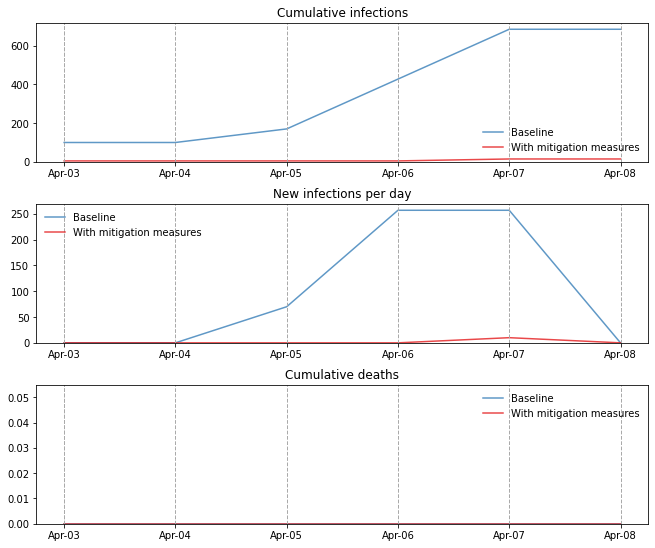

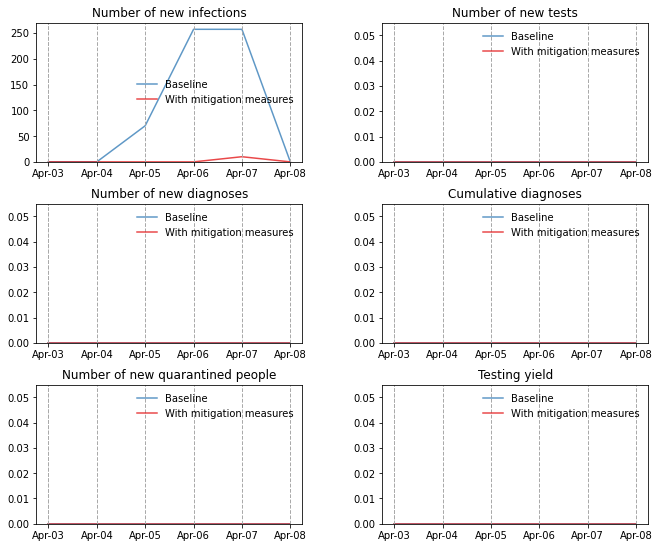

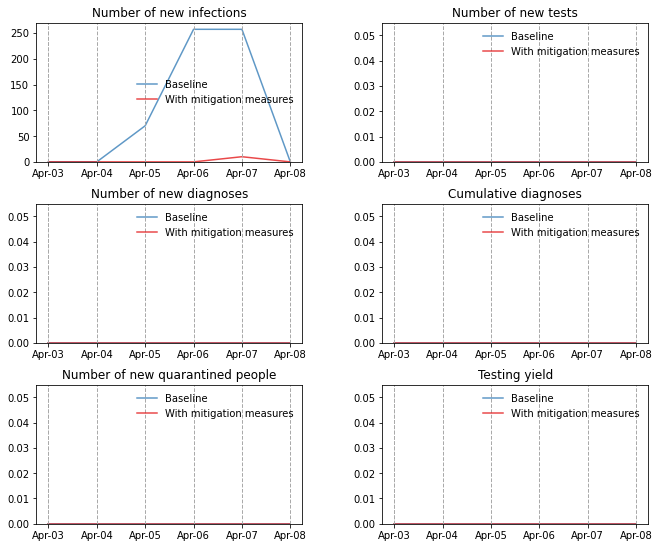

In [153]:
# Run and plot
msim = cv.MultiSim([orig_sim, sim])
msim.run()
msim.plot()
msim.plot(to_plot=['new_infections', 'new_tests', 'new_diagnoses', 'cum_diagnoses', 'new_quarantined', 'test_yield'])
